# Damage Size Regression on Real-world Data Data - Baseline
In this notebook, we conduct experiments to be able to compare to a baseline. Just to make sure, we repeat the experiment several times to make sure that the previously established cross-validation setup gives reliable results also with this approach.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/berni-lehner/structural_health_monitoring/blob/main/notebooks/mixed_regression_AA_BASE.ipynb)

In [1]:
random_state = None

## Prerequisites

In [2]:
import os
import sys
from pathlib import Path

import pandas as pd

# initialize environment, paths, etc...
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    # uncomment in case you want to start from scratch in Colab
    !rm -rf /content/structural_health_monitoring
    !git clone https://github.com/berni-lehner/structural_health_monitoring.git
    !pip install -r /content/structural_health_monitoring/requirements.txt

    # this is Colab specific, and only a manual "Run all" will cause the
    # installation to be finished
    if pd.__version__ != "1.4.2":
        print("Stopping RUNTIME! Please run again to finish installation.")
        os.kill(os.getpid(), 9)

    DATA_PATH = Path(r"/content/structural_health_monitoring/data")
    sys.path.insert(0, "/content/structural_health_monitoring/src")
else:
    DATA_PATH = Path(r"../data/")
    sys.path.insert(0, "../src")


sys.path.insert(0, DATA_PATH)
SYN_DATA_PATH = Path(DATA_PATH, "synthetic")
REAL_DATA_PATH = Path(DATA_PATH, "real_world")
RESULT_PATH = Path(DATA_PATH, "results")
if not os.path.isdir(RESULT_PATH):
    os.makedirs(RESULT_PATH)

try:
    from zippeekiyay import namelist
except ImportError or ModuleNotFoundError:
    print("installing zippee-ki-yay...")
    !pip install git+https://github.com/berni-lehner/zippee-ki-yay.git

    from zippeekiyay import namelist

CALIBRATION_FILE = Path(REAL_DATA_PATH, "calibration.pkl")

In [3]:
# Intel(R) Extension for Scikit-learn for speed-up
from sklearnex import patch_sklearn

patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
import glob
import time
from collections import Counter

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn

# ...and download raw data if not already downloaded
from data_utils import init_data

# init_data(syn_data_path=SYN_DATA_PATH, real_data_path=REAL_DATA_PATH)

from plot_utils import (
    init_plotting,
    plot_classwise_dist,
    plot_classwise_kde,
    plot_cv_indices,
    plot_embedding_targets,
    plot_metrics,
)

# configure fonts, etc...
init_plotting()

from bench_utils import classification_benchmark, extract_metrics, repeat_experiment
from cv_utils import (
    AnomalyShuffleSplit,
    CreateAnomalyData,
    RepeatedAnomalyShuffleSplit,
    dump_cv,
)
from data_utils import FEATURE_LIST, load_reg_data_base, load_syn_reg_data
from scoring_utils import SHM_Scoring, get_real_regression_scoring
from shm_experiments import conduct_aa_mixed_reg_experiment

In [5]:
result_file = "mixed_regression_AA_baseline_dssize_mlp.pkl"
result_file = Path(RESULT_PATH, result_file)

## Data Loading

### Synthetic Data

In [6]:
# Xsyn, ysyn = load_reg_data_base(data_path=SYN_DATA_PATH,
#                                 min_radius = 1.9,
#                                 cache=True)

Xsyn, ysyn = load_syn_reg_data(data_path=SYN_DATA_PATH, min_radius=1.9, cache=True)

In [7]:
Xsyn.shape

(28302, 31)

In [8]:
ctr = Counter(ysyn)
ctr

Counter({0.0: 990,
         3.1: 986,
         28.0: 983,
         6.7: 981,
         16.0: 980,
         24.0: 980,
         2.2: 979,
         2.5: 979,
         4.4: 979,
         2.8: 978,
         14.0: 978,
         5.0: 977,
         30.0: 977,
         4.1: 976,
         4.7: 976,
         18.0: 976,
         36.0: 976,
         22.0: 975,
         20.0: 974,
         3.8: 973,
         10.0: 973,
         26.0: 973,
         3.4: 972,
         8.3: 972,
         34.0: 971,
         12.0: 969,
         40.0: 968,
         32.0: 967,
         38.0: 964})

### Real World Data

In [9]:
# Xreal, yreal = load_reg_data_base(data_path=REAL_DATA_PATH,
#                                   min_radius = 1.,
#                                   cache=False,
#                                   synthetic=False,
#                                   calibration_file=CALIBRATION_FILE)

Xreal, yreal = load_syn_reg_data(
    data_path=REAL_DATA_PATH,
    min_radius=1.0,
    synthetic=False,
    calibration_file=CALIBRATION_FILE,
)

In [10]:
Xreal.shape

(225, 31)

In [11]:
ctr = Counter(yreal)
ctr

Counter({0.0: 9,
         1.5: 9,
         10.0: 9,
         12.0: 9,
         14.0: 9,
         16.0: 9,
         17.0: 9,
         19.0: 9,
         2.5: 9,
         21.0: 9,
         23.0: 9,
         25.0: 9,
         27.0: 9,
         29.0: 9,
         3.5: 9,
         31.0: 9,
         33.0: 9,
         35.0: 9,
         37.0: 9,
         39.0: 9,
         4.5: 9,
         40.0: 9,
         5.5: 9,
         7.0: 9,
         8.0: 9})

## A-A Experiments

In [12]:
from functools import partial

from imblearn.base import FunctionSampler
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import ClusterCentroids
from manifold_utils import tsne_embedding
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import OrdinalEncoder

In [13]:
def resampling(X, y=None, sampler=lambda *_: _, **_):
    enc = OrdinalEncoder(dtype=np.int32)

    y_cls = enc.fit_transform(y.reshape(-1, 1))
    x_re, y_recls = sampler.fit_resample(X, y_cls)
    y_re = enc.inverse_transform(y_recls.reshape(-1, 1))

    return x_re, y_re.ravel()


def build_pipeline(samples_per_class, n_classes, random_state=None):
    n_samples = samples_per_class * n_classes
    strgy = dict(zip(range(n_classes), [samples_per_class] * n_classes))
    cc = ClusterCentroids(
        estimator=KMeans(n_init="auto"),
        sampling_strategy=strgy,
        random_state=random_state,
    )

    estimator = MLPRegressor(
        hidden_layer_sizes=(48,32,),
        learning_rate="adaptive",
        max_iter=10000,
        solver="lbfgs",
    )
    pipeline = Pipeline(
        [
            (
                "sampler",
                FunctionSampler(
                    func=resampling, kw_args=dict(sampler=cc), validate=False
                ),
            ),
            ("est", estimator),
        ],
        verbose=False,
    )

    return pipeline


classes, counts = np.unique(ysyn, return_counts=True)
n_target = len(classes)
max_samples_per_target = np.floor(np.min(counts) * 0.85) - 1

pipeline = build_pipeline(
    samples_per_class=2, n_classes=n_target, random_state=random_state
)

In [14]:
scoring = get_real_regression_scoring()

results = conduct_aa_mixed_reg_experiment(
    Xsyn=Xsyn,
    ysyn=ysyn,
    Xreal=Xreal,
    yreal=yreal,
    estimator=pipeline,
    name="BASE",
    n_repeats=5,
    n_splits=32,
    test_size=0.1,
    scoring=scoring,
    random_state=random_state,
)

## Store results for later

In [15]:
results.to_pickle(result_file)

## Plot some results for overview

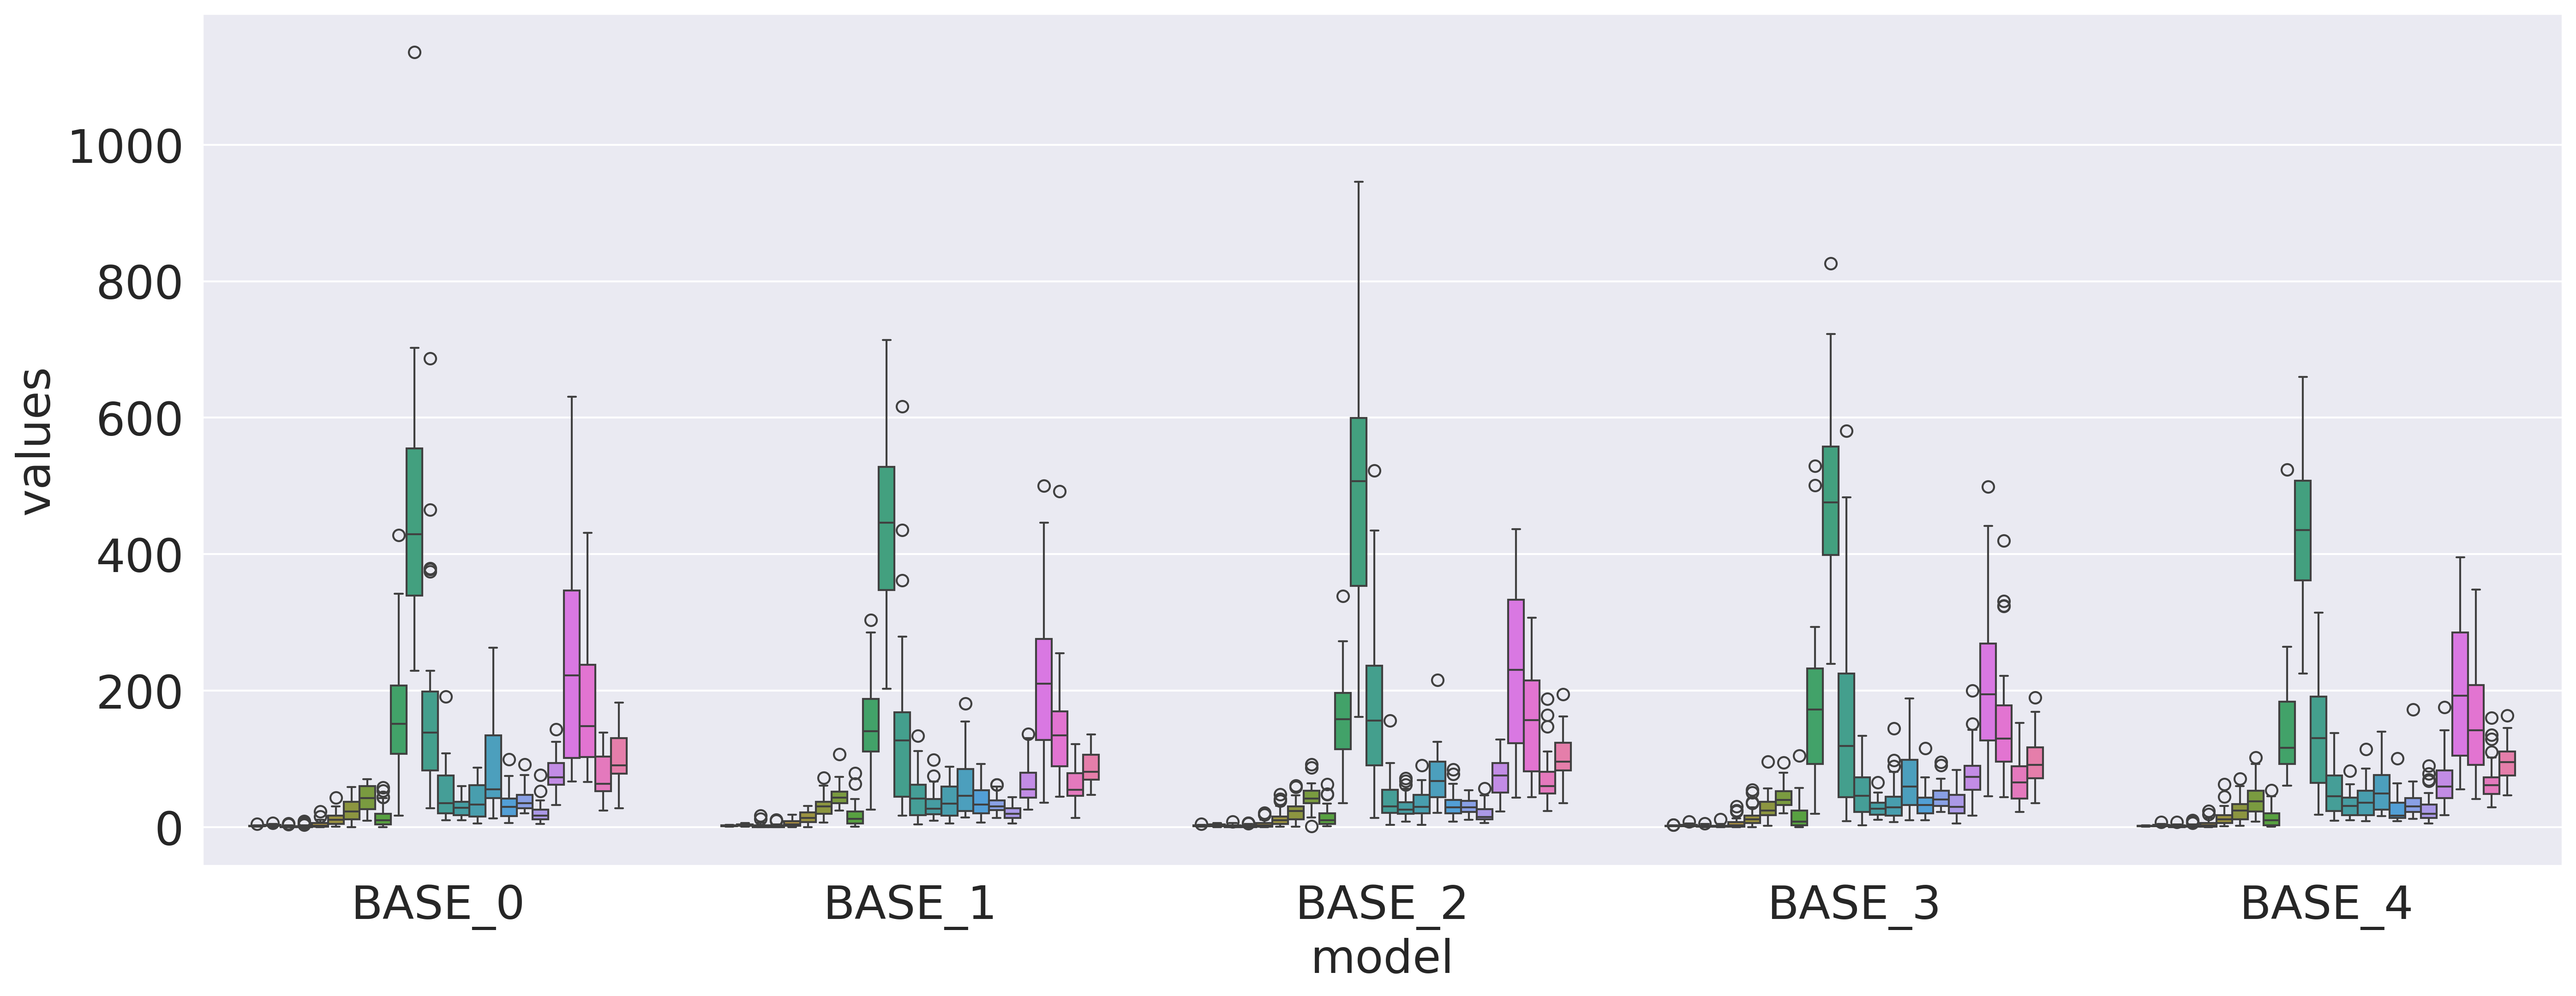

In [16]:
shm_scoring = SHM_Scoring()

fig = plot_metrics(extract_metrics(results, shm_scoring.REAL_MSE_RESULTS))
plt.gca().get_legend().remove()
plt.show()

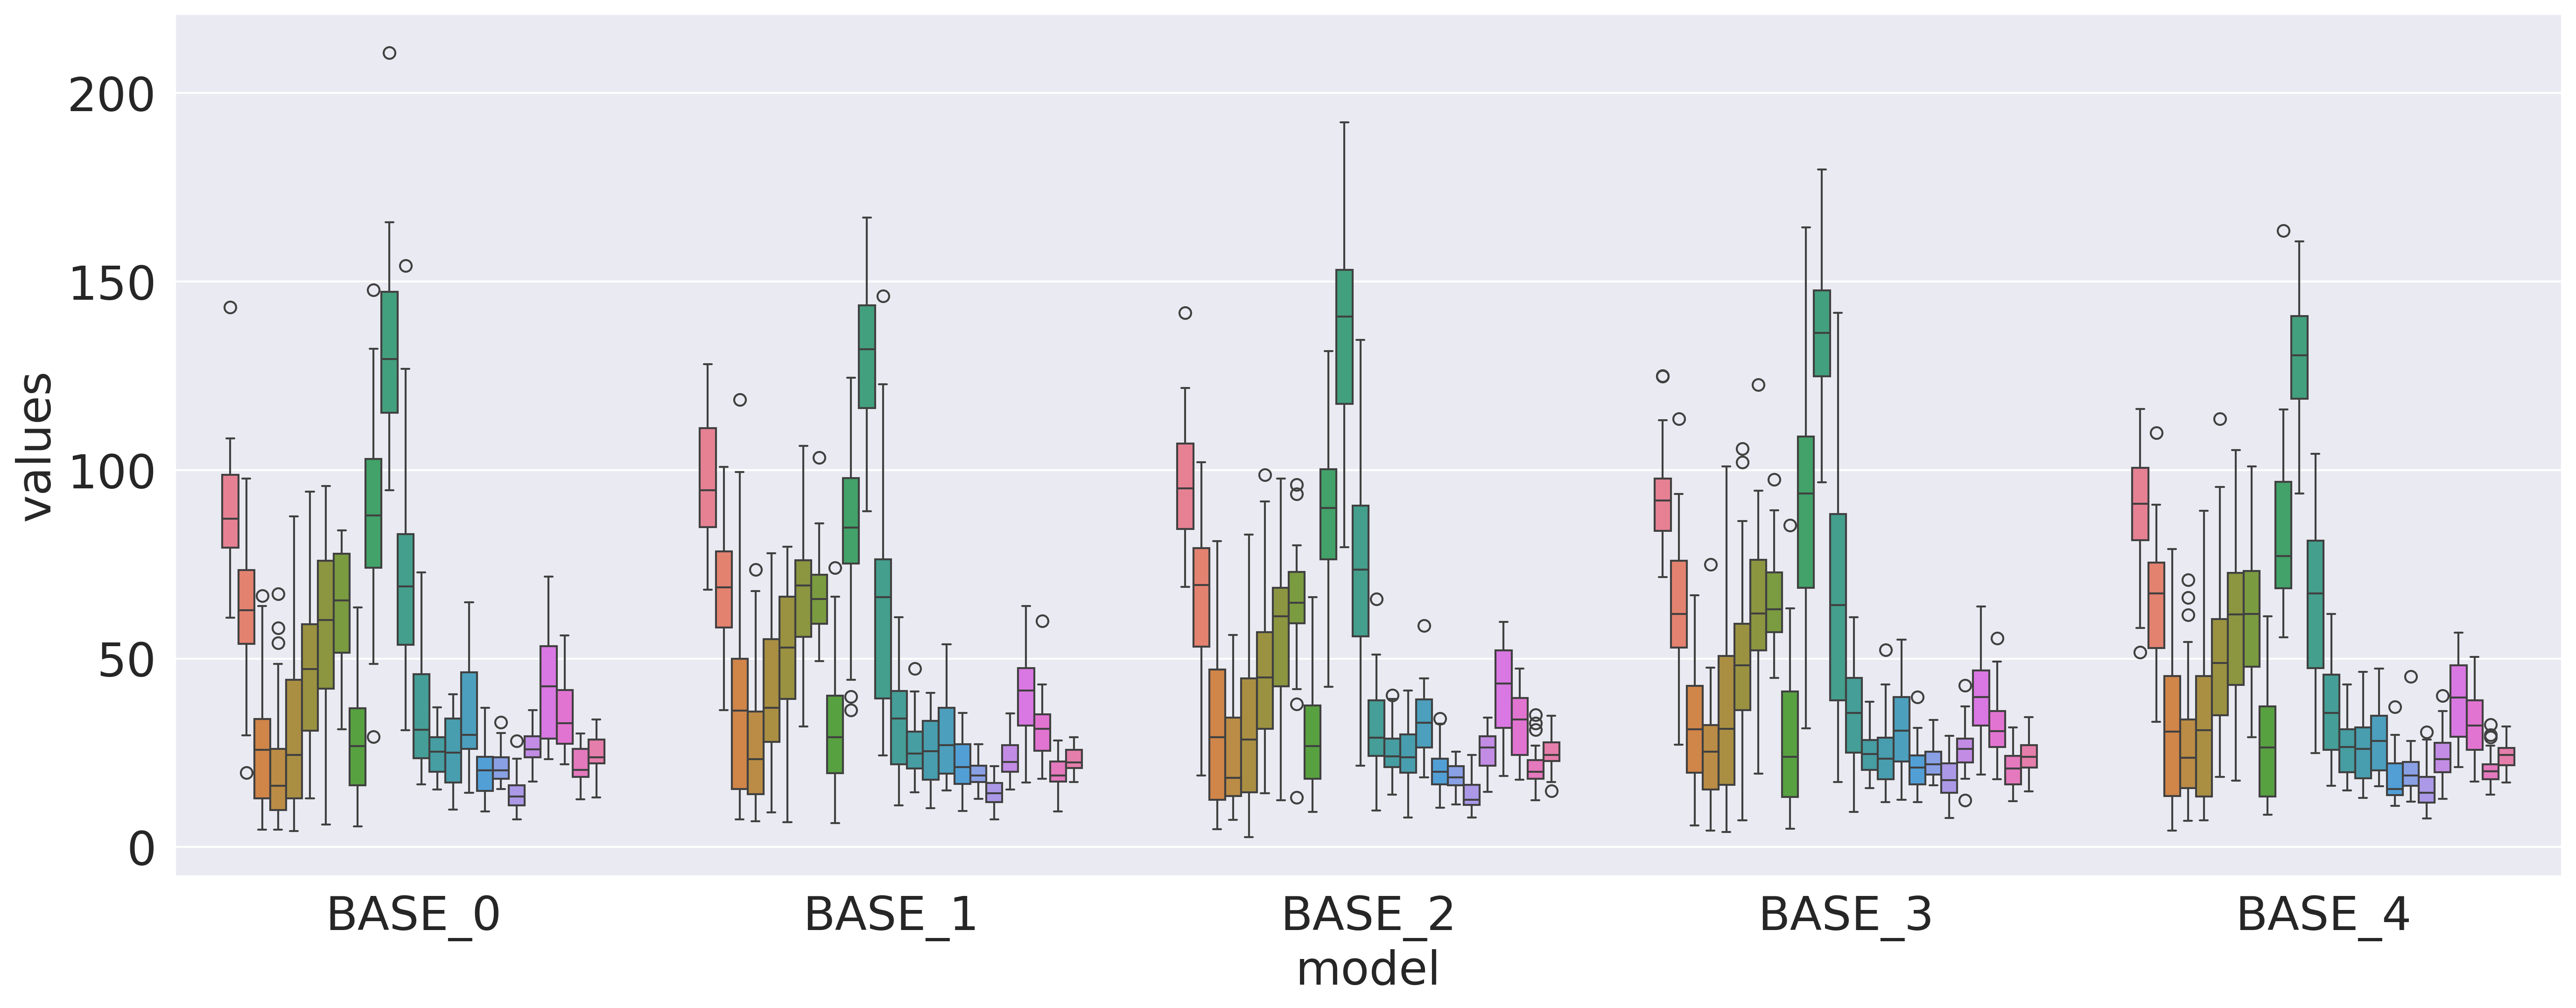

In [17]:
fig = plot_metrics(extract_metrics(results, shm_scoring.REAL_REL_ERROR))
plt.gca().get_legend().remove()
plt.show()

In [18]:
def build_pipeline(samples_per_class, n_classes, random_state=None):
    n_samples = samples_per_class * n_classes
    strgy = dict(zip(range(n_classes), [samples_per_class] * n_classes))
    cc = ClusterCentroids(
        estimator=KMeans(n_init="auto"),
        sampling_strategy=strgy,
        random_state=random_state,
    )

    estimator = MLPRegressor(
        hidden_layer_sizes=(48,32,32,),
        learning_rate="adaptive",
        max_iter=10000,
        solver="lbfgs",
    )
    pipeline = Pipeline(
        [
            (
                "sampler",
                FunctionSampler(
                    func=resampling, kw_args=dict(sampler=cc), validate=False
                ),
            ),
            ("est", estimator),
        ],
        verbose=False,
    )

    return pipeline

In [19]:
pipeline = build_pipeline(
    samples_per_class=2, n_classes=len(ctr), random_state=random_state
)
pipeline.fit(Xsyn, ysyn)
y_pred = pipeline.predict(Xreal)
y_pred

array([-4.77910274e-01, -3.24537700e-01, -2.97010068e-01, -2.18781988e-01,
       -4.84863658e-01, -4.80791651e-01, -4.31120372e-01, -4.57347096e-01,
       -4.58238961e-01,  1.55526048e+00, -1.56916732e+00,  1.15544820e+01,
        2.75696762e+01,  3.27639391e+01,  2.90222164e+00,  2.86111900e+00,
        2.35320554e+00, -7.29965886e-01,  1.23075332e+01,  3.80039925e+01,
        1.01911722e+01,  2.34545100e+01,  3.86985616e+00,  2.64415987e+01,
        3.74628640e+01,  3.37861533e+01,  3.54612085e+01,  4.16568227e+01,
        6.80203402e+00,  4.14410120e+01,  6.61758292e+00,  6.94991267e+00,
        3.63152419e+00,  2.18527722e+00, -1.45786503e+00,  1.17486227e+01,
        2.51028706e+01,  3.27915659e+01,  5.53168012e+00, -8.66286062e-02,
        2.65874379e+00,  1.29970420e+01,  3.10722109e+01,  2.41269441e+01,
        1.31394841e+01,  3.16566390e+01,  4.23838528e+00,  3.33240324e+01,
        3.64453703e+01,  3.49344134e+01,  3.81210698e+01,  4.16530408e+01,
        7.05733992e+00,  

In [20]:
sidx = yreal.argsort()

<Axes: >

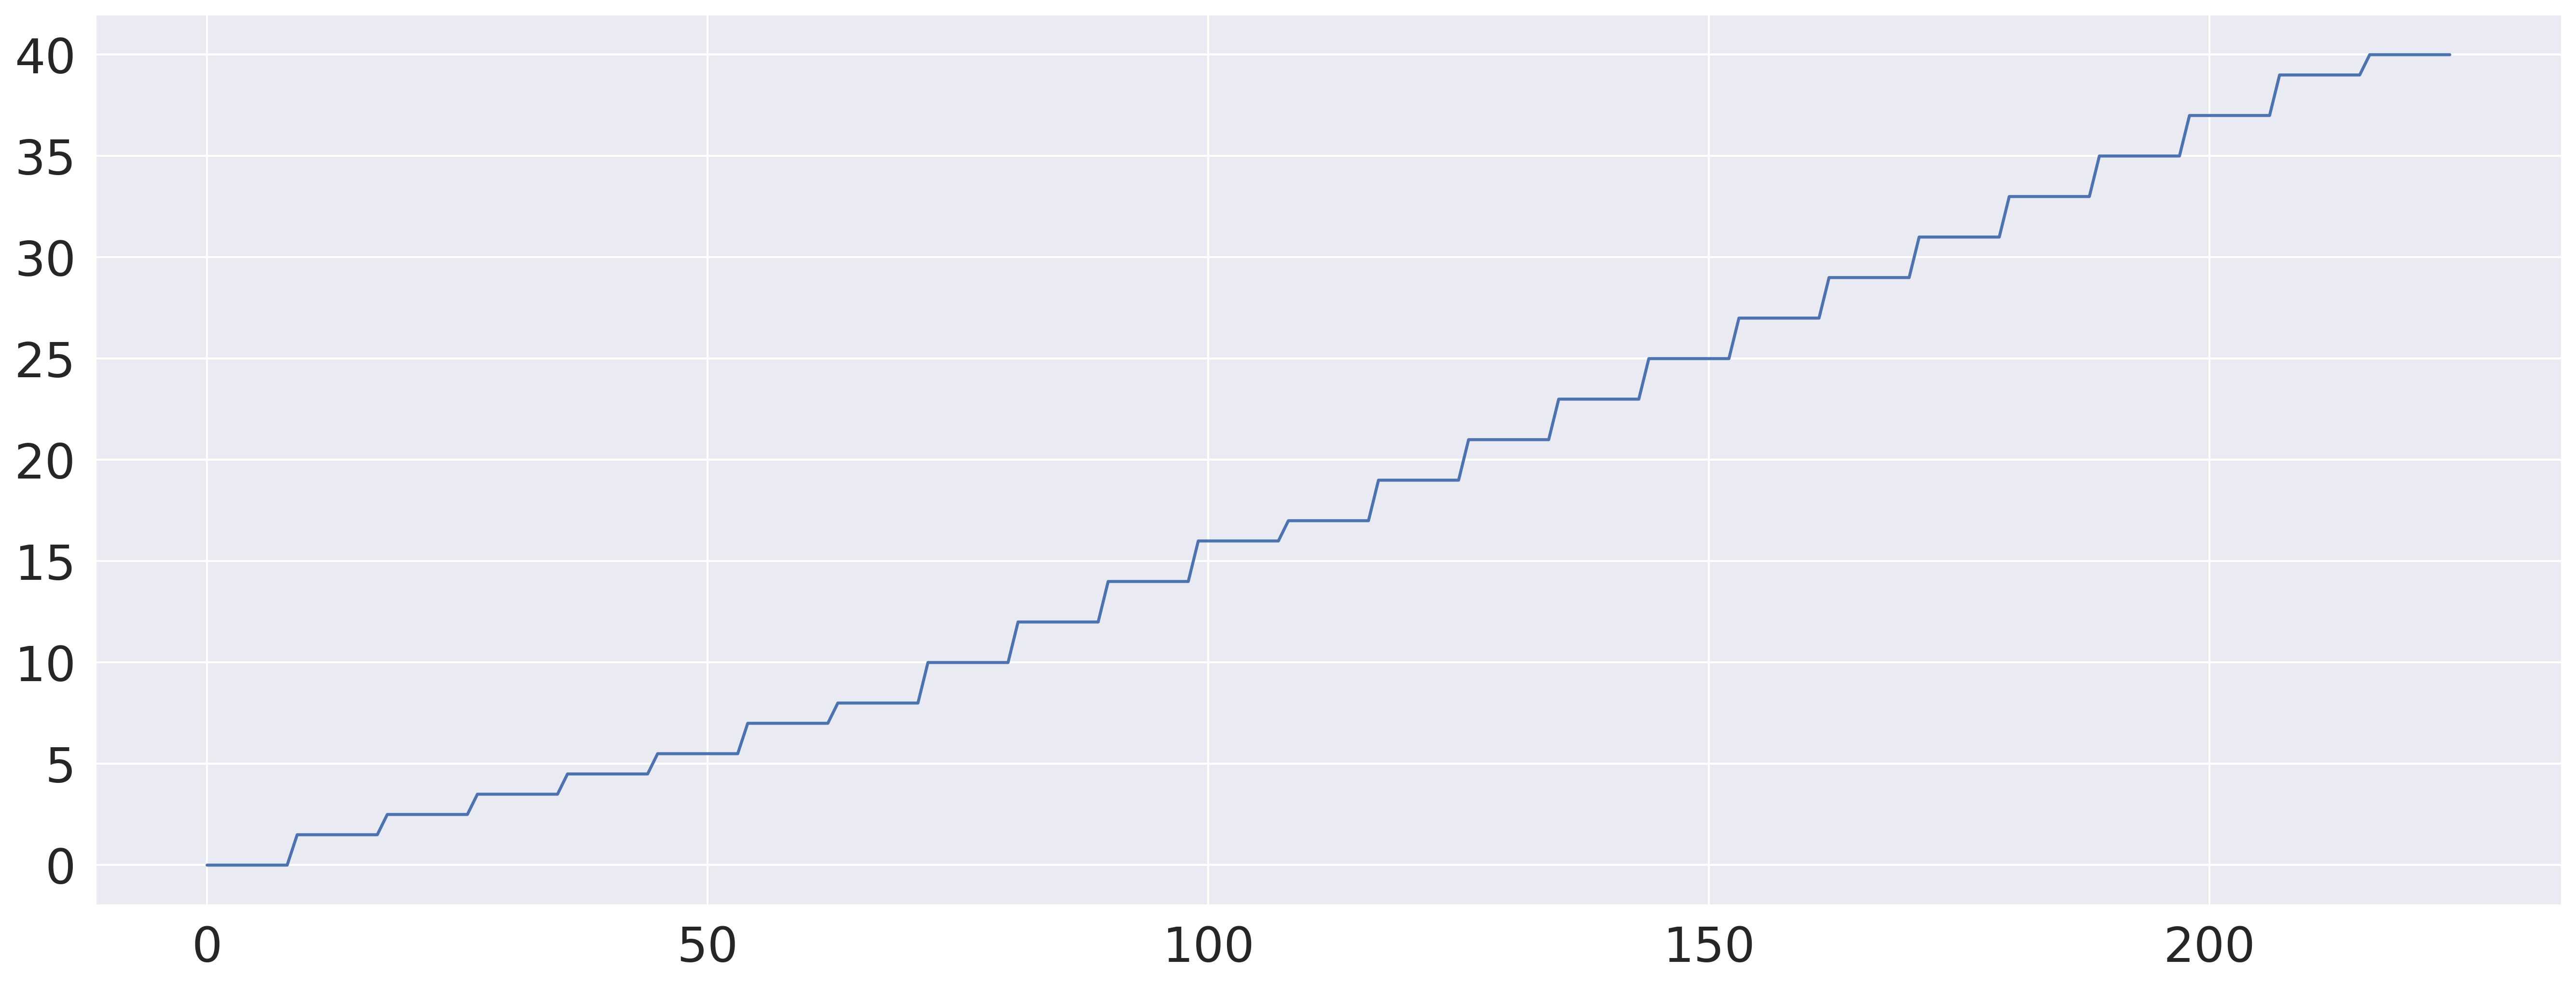

In [21]:
sns.lineplot(yreal[sidx])

<Axes: >

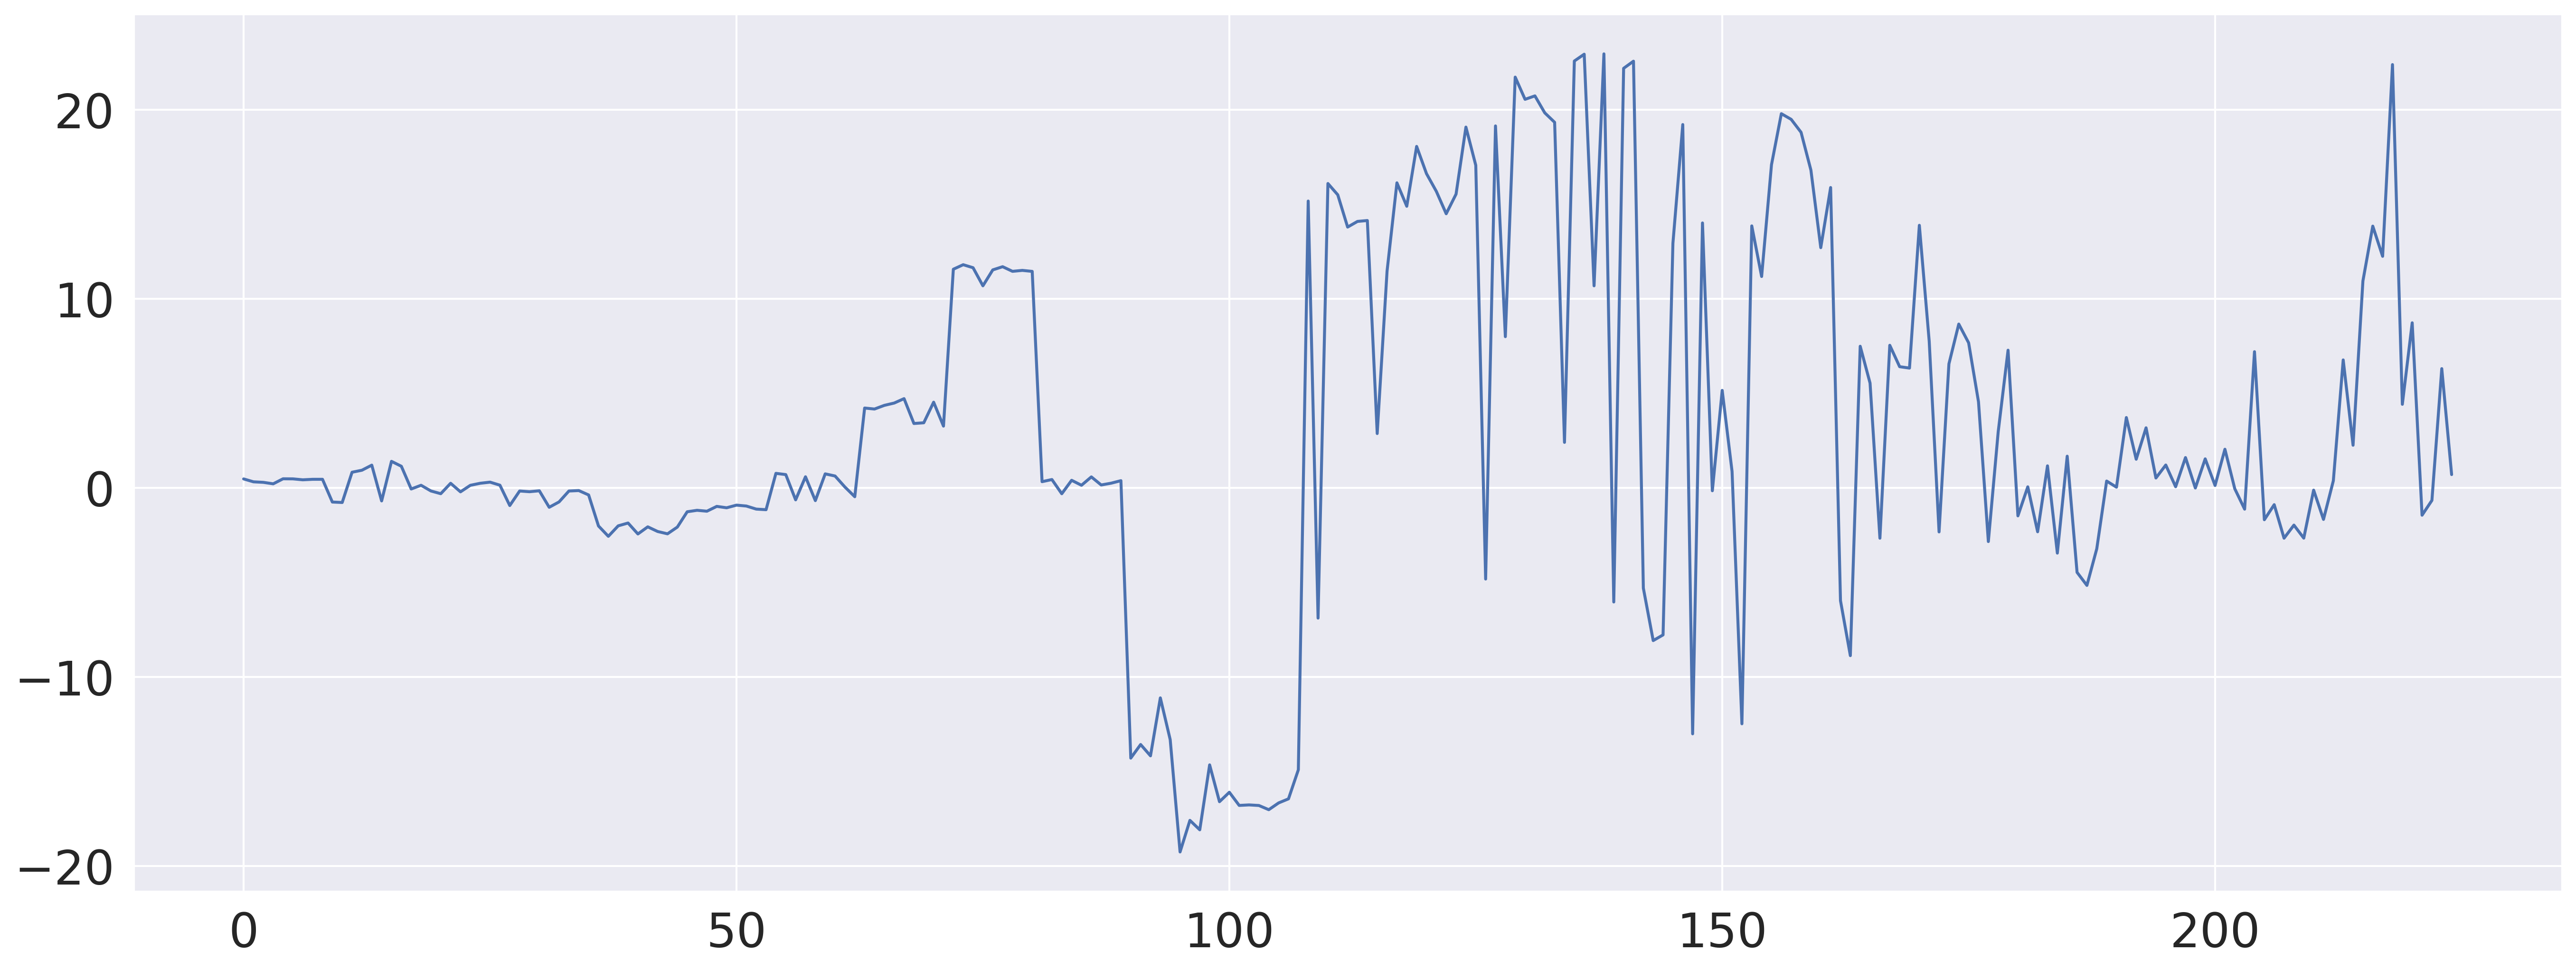

In [22]:
sns.lineplot(yreal[sidx] - y_pred[sidx])

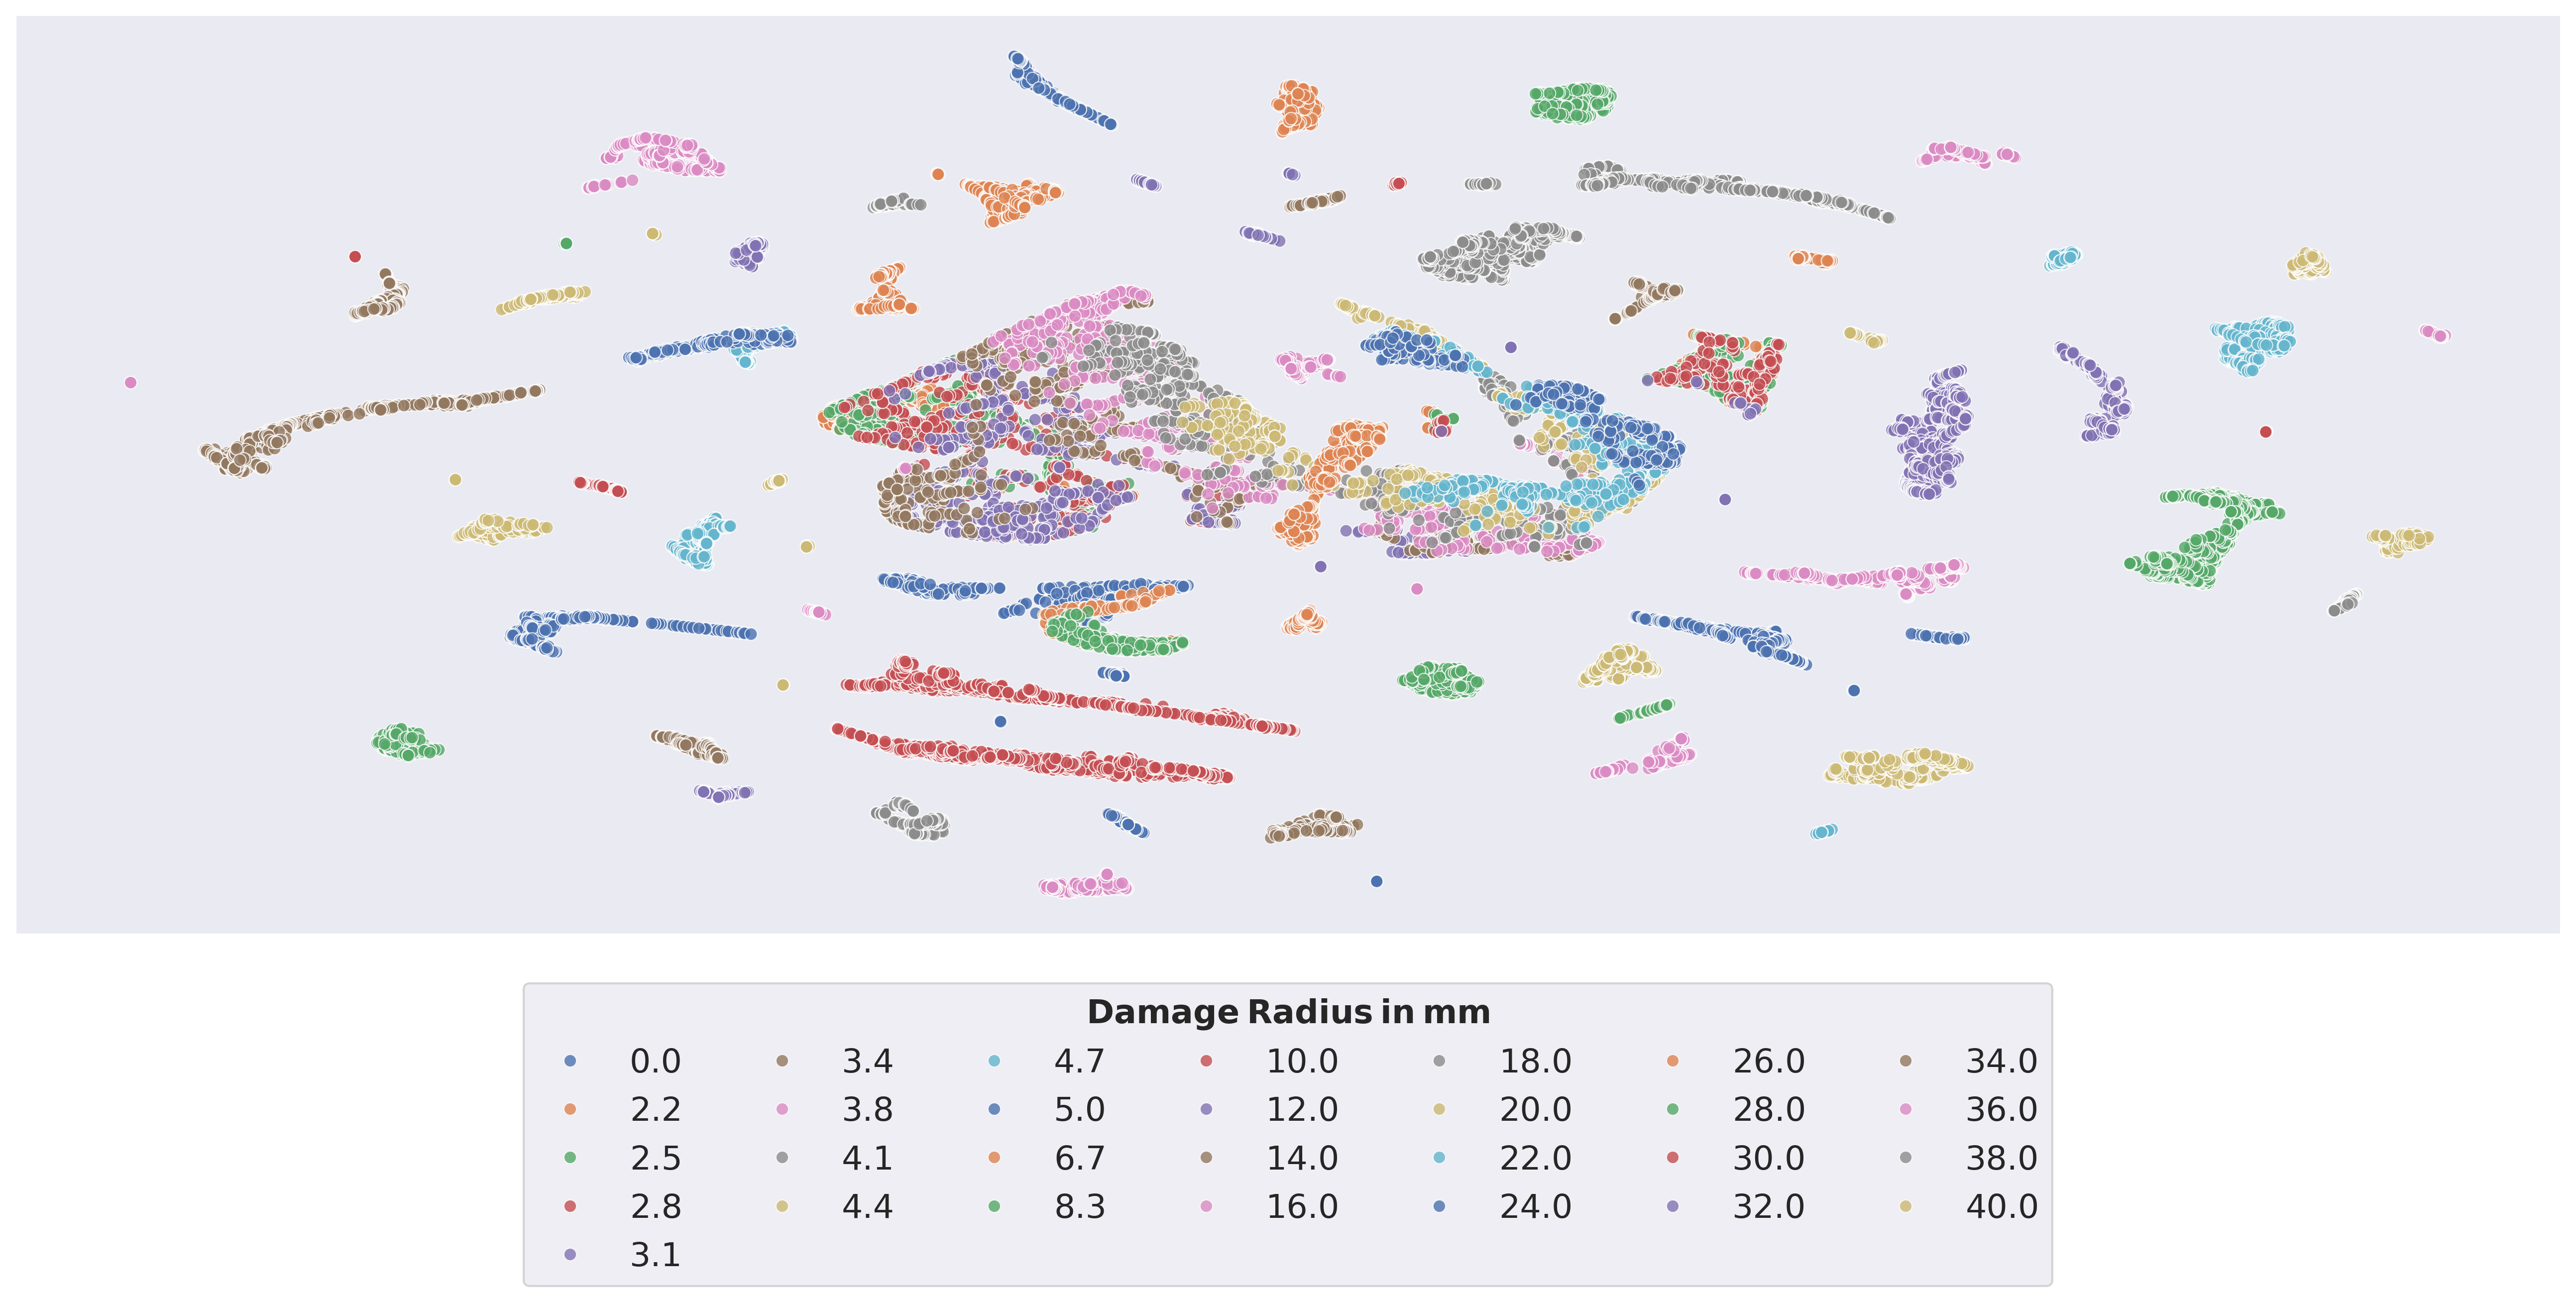

In [23]:
from manifold_utils import umap_embedding

umap, X_embedded = umap_embedding(X=Xsyn, n_neighbors=15)

palette = dict(zip(np.unique(ysyn), sns.color_palette(None, len(np.unique(ysyn)))))
fig = plot_embedding_targets(X_embedded, y=ysyn, alpha=0.8, palette=palette)

legend = plt.legend(
    ncol=7,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.4),
    title_fontsize=16,
    fontsize=16,
)
legend.set_title("$\\bf{Damage\:Radius\:in\:mm}$")

plt.xticks([])
plt.yticks([]);

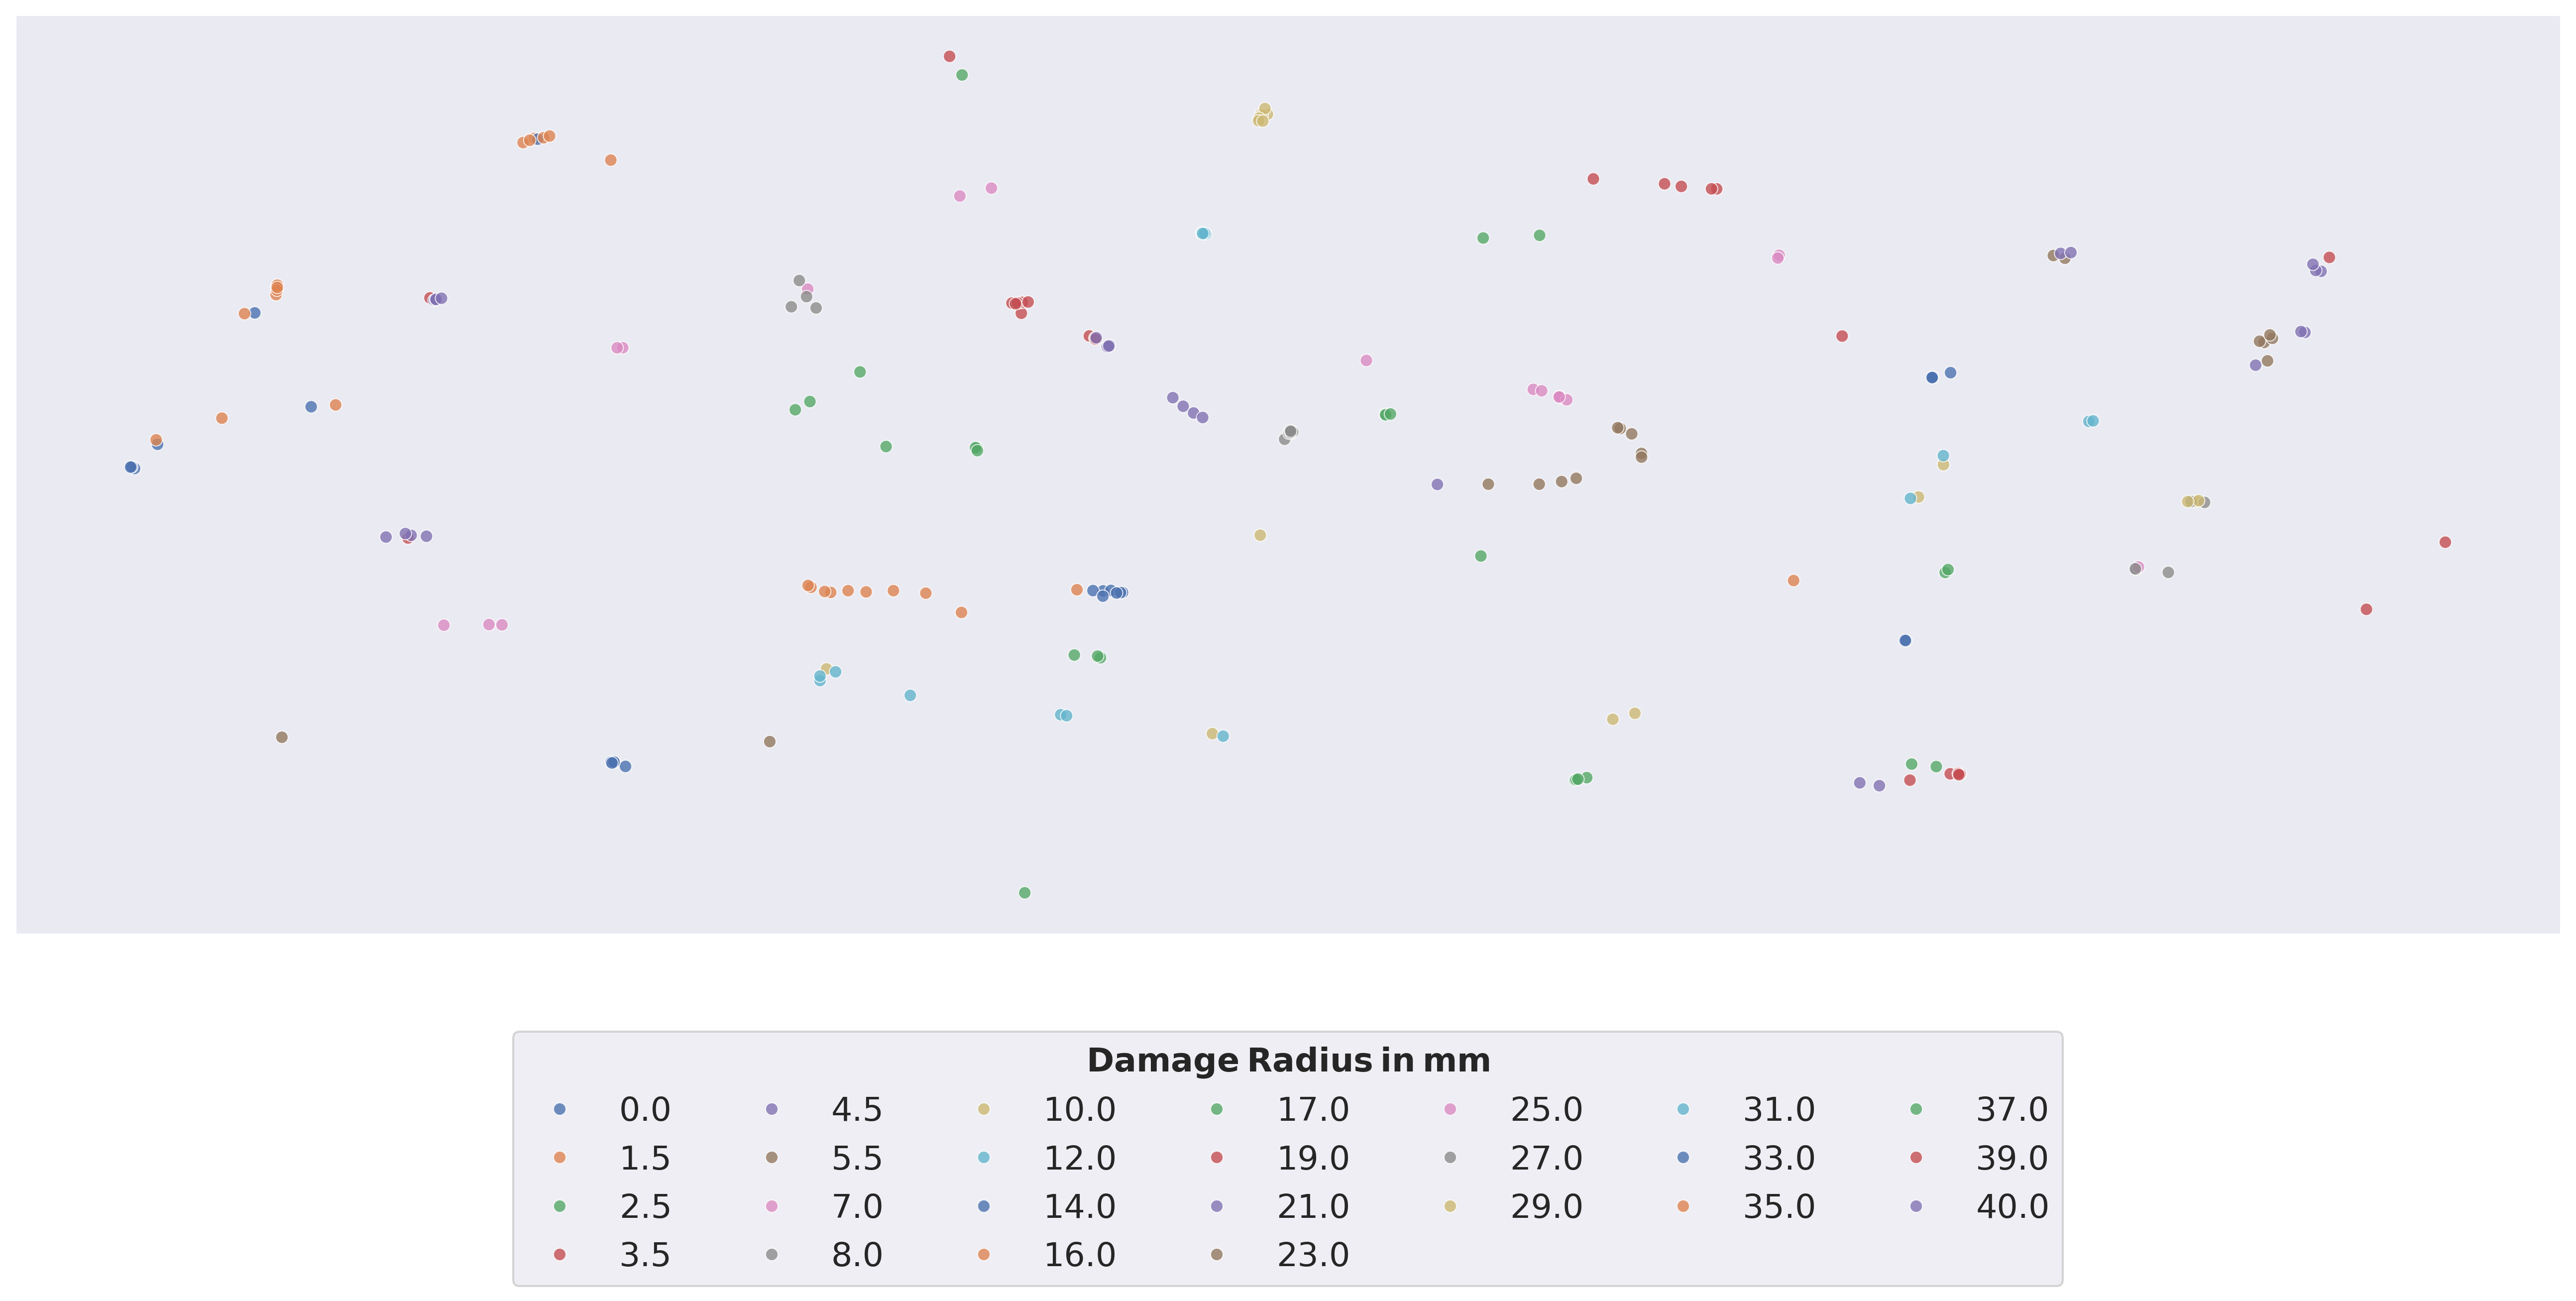

In [24]:
X_embedded = umap.transform(Xreal)

palette = dict(zip(np.unique(yreal), sns.color_palette(None, len(np.unique(yreal)))))
fig = plot_embedding_targets(X_embedded, y=yreal, alpha=0.8, palette=palette)

legend = plt.legend(
    ncol=7,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.4),
    title_fontsize=16,
    fontsize=16,
)
legend.set_title("$\\bf{Damage\:Radius\:in\:mm}$")

plt.xticks([])
plt.yticks([]);

In [30]:
import plotly.express as px
import plotly.graph_objects as go


def plot_errors(feat_embedding, trg, pred):
    sc1 = px.scatter_3d(
        x=feat_embedding[..., 0],
        y=feat_embedding[..., 1],
        z=yreal,
        color=yreal / 4,
        title="Target",
    )
    sc2 = px.scatter_3d(
        x=feat_embedding[..., 0],
        y=feat_embedding[..., 1],
        z=y_pred,
        color=(yreal - y_pred) ** 2,
        title="Prediction",
    )

    line_xy = np.repeat(feat_embedding, repeats=3, axis=0)
    line_xy[2::3] = None

    line_z = np.empty((3 * trg.shape[0],))
    line_z[::3] = trg
    line_z[1::3] = pred
    line_z[2::3] = None

    sc3 = go.Scatter3d(
        x=line_xy[..., 0], y=line_xy[..., 1], z=line_z, mode="lines", marker_size=2
    )

    fig = go.Figure(data=sc1.data + sc2.data + (sc3,))

    fig.data[1].marker.symbol = "x"
    fig.update_traces(marker_size=3, line=dict(color="purple", width=5))
    fig.update_layout(
        autosize=False,
        width=1200,
        height=1200,
    )

    return fig


plot_errors(X_embedded, yreal, y_pred)

<Axes: ylabel='Count'>

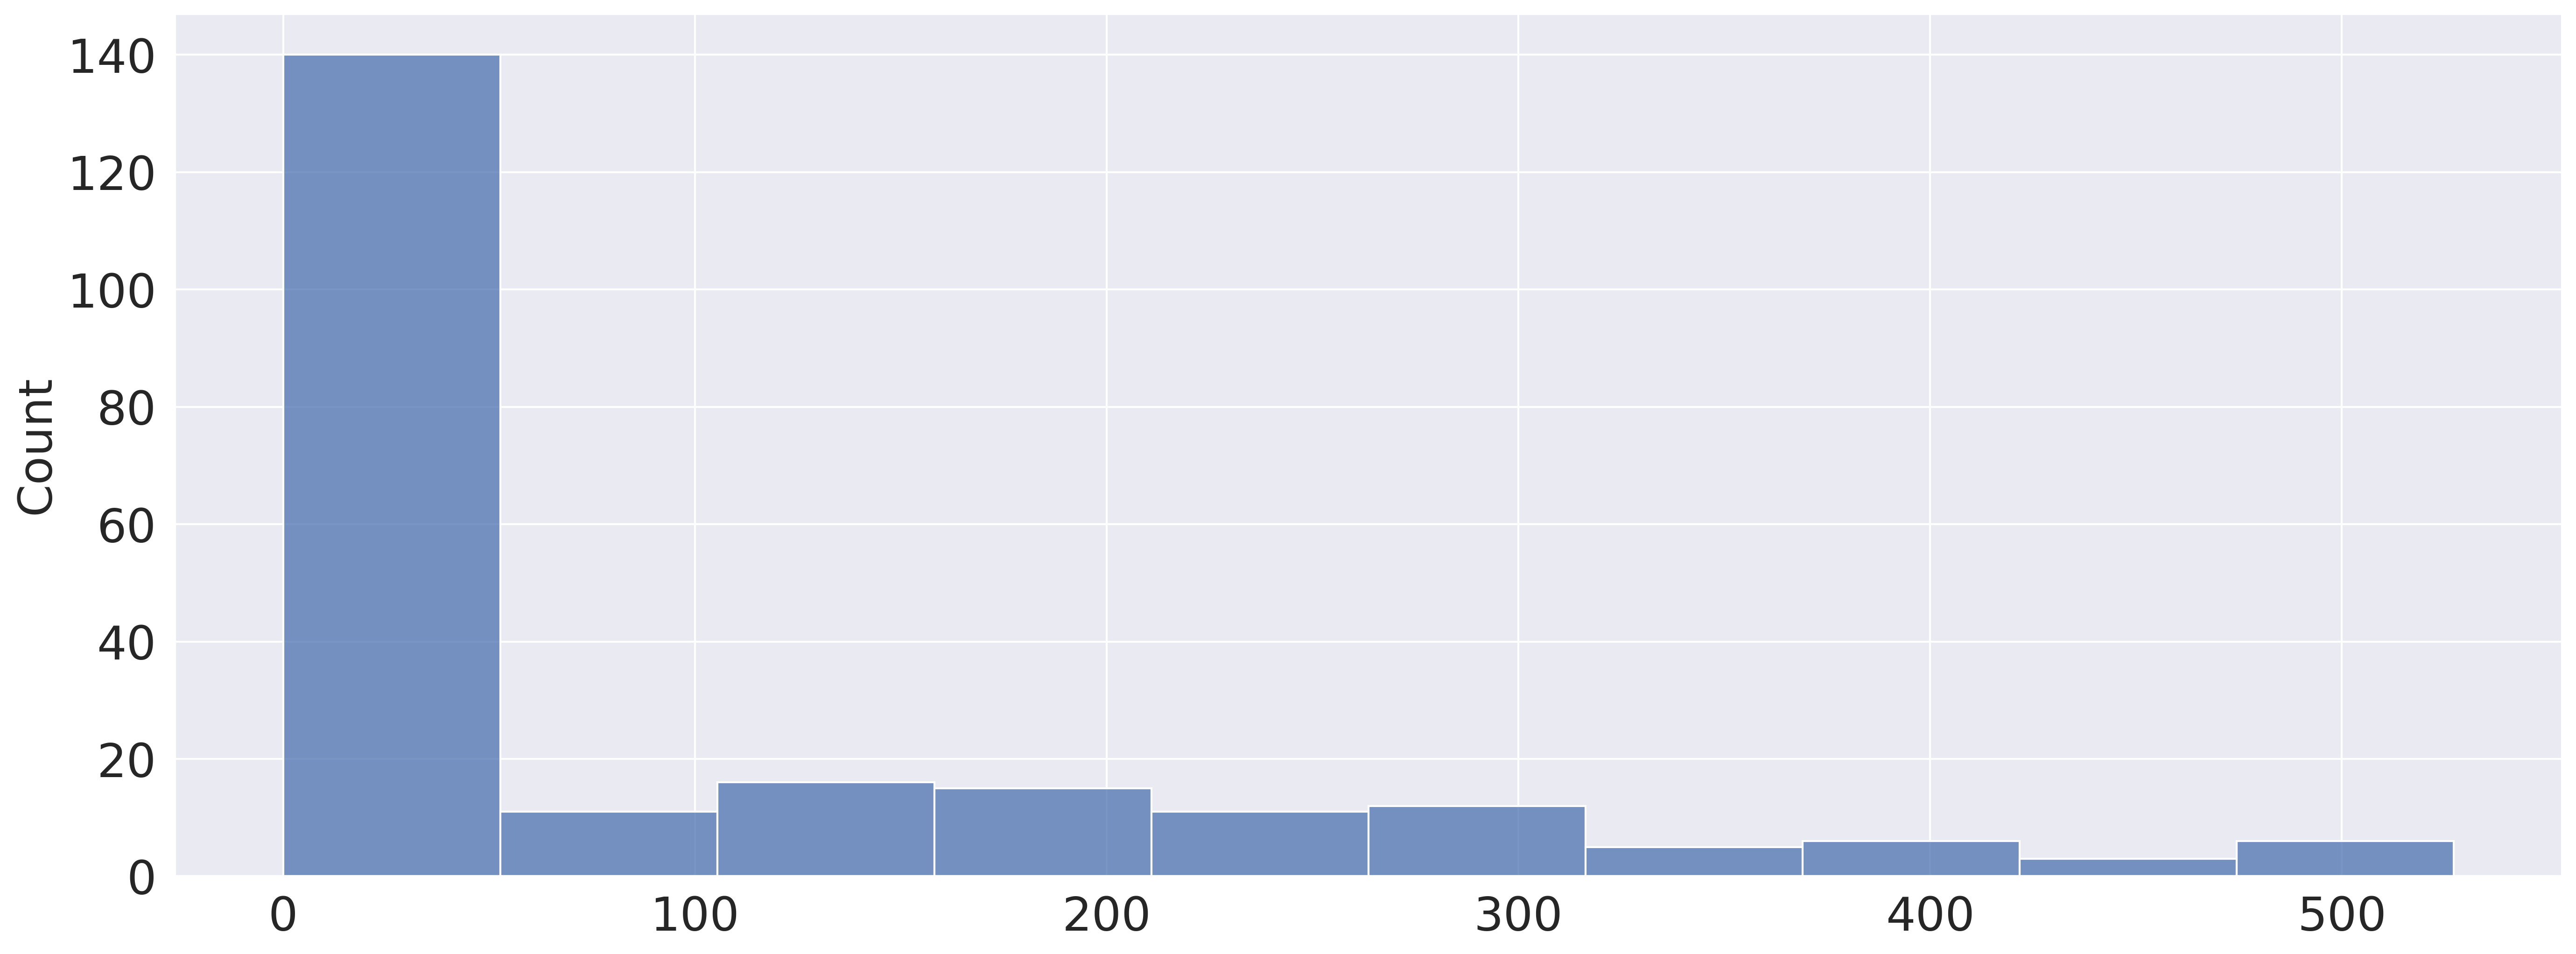

In [26]:
sns.histplot((yreal - y_pred) ** 2)

/home/huberc/sw/mambaforge/envs/quick/lib/python3.9/site-packages/seaborn/categorical.py:3370: UserWarning:

70.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



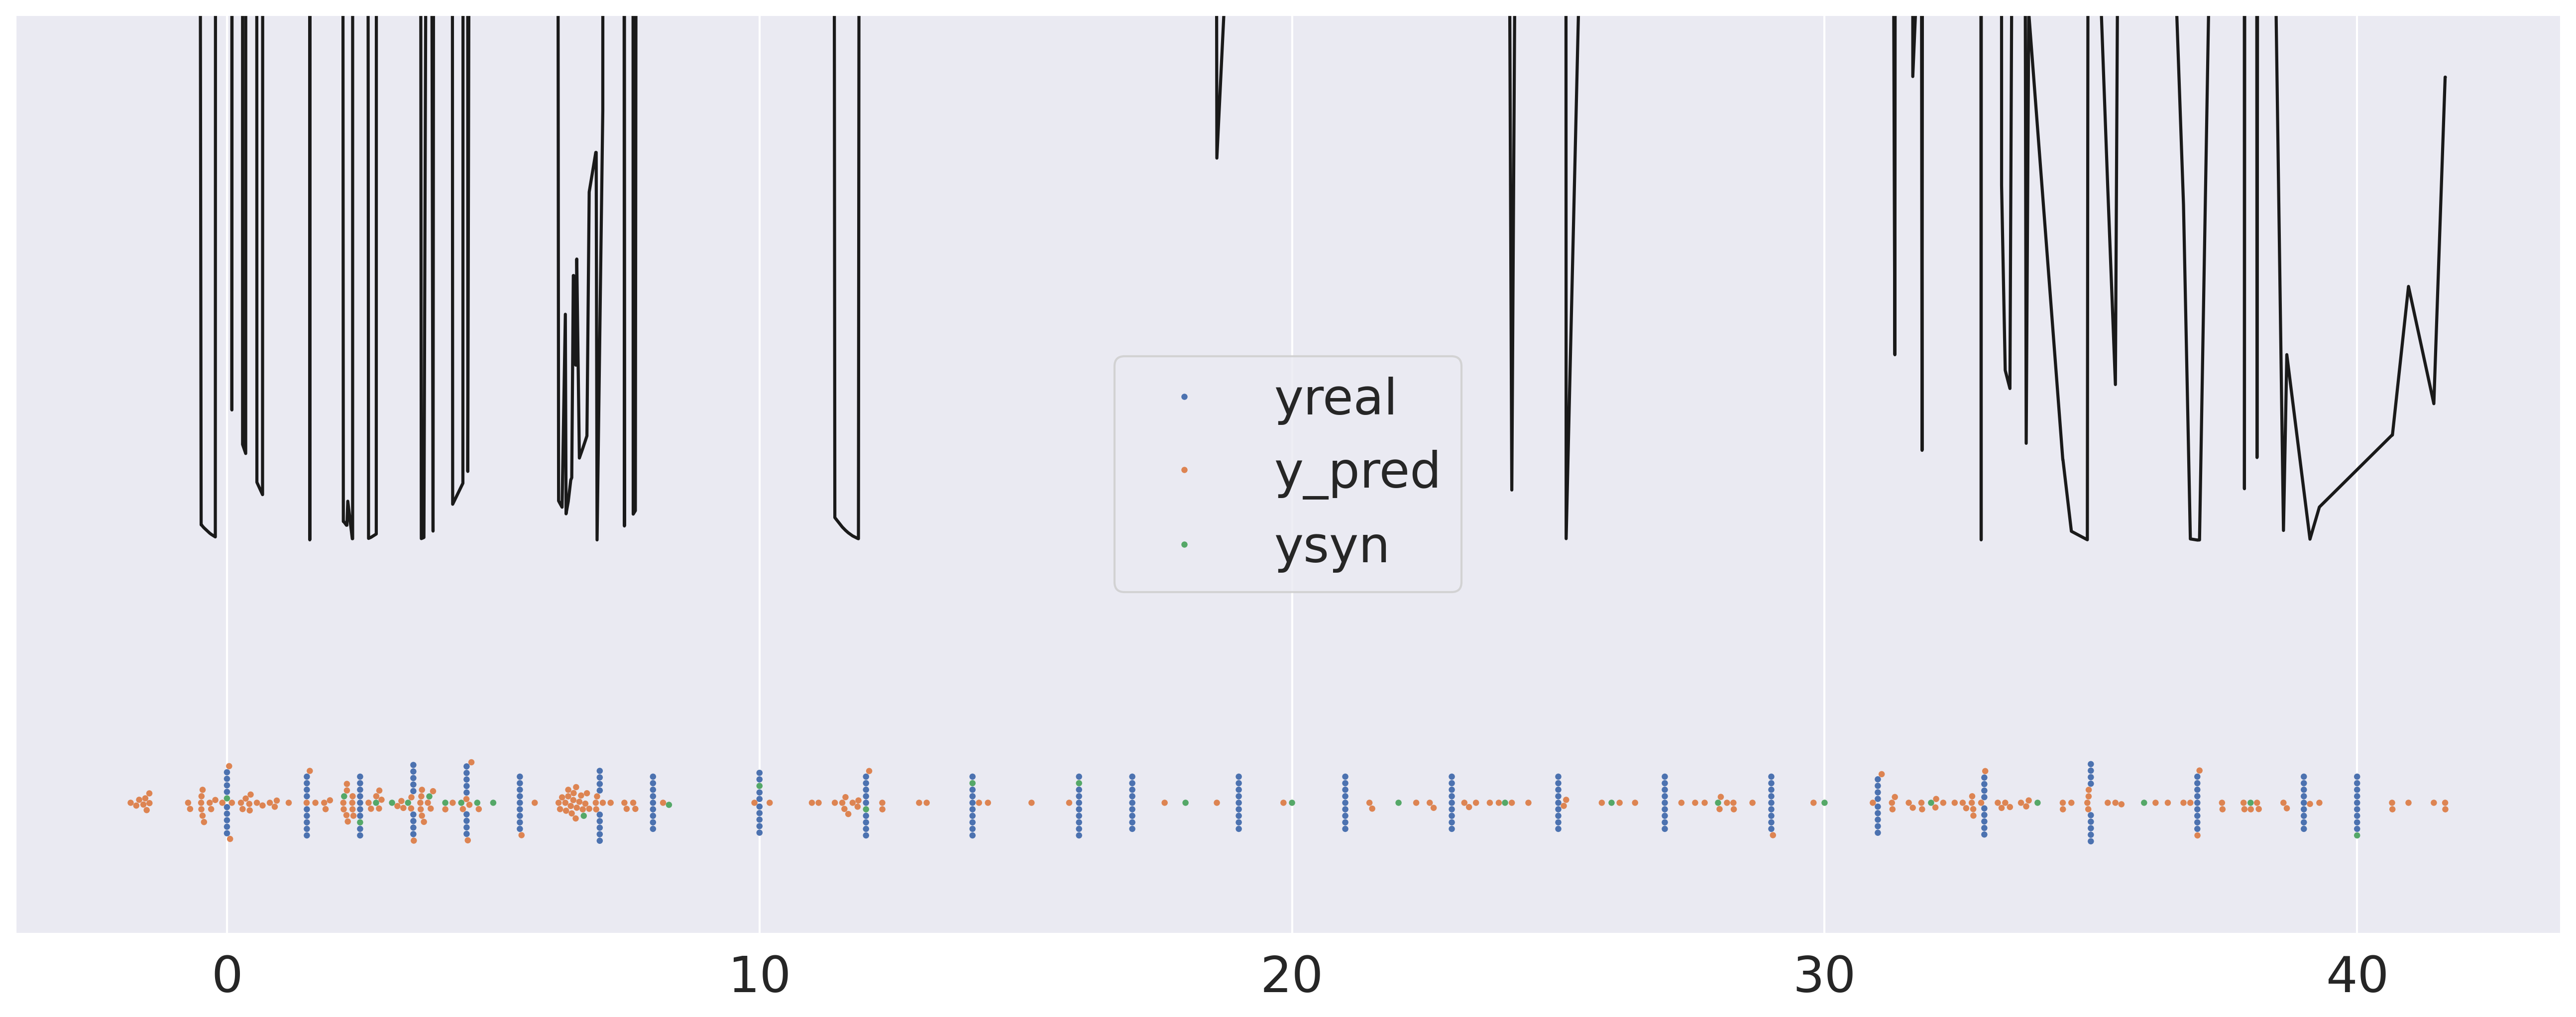

In [27]:
y_data = [
    (
        (
            yreal[np.argwhere(np.abs(y_pred - l) < 0.01)]
            - y_pred[np.argwhere(np.abs(y_pred - l) < 0.01)]
        )
        ** 2
    ).mean()
    / 4
    + 1
    for l in np.unique(y_pred)
]
sns.lineplot(x=np.unique(y_pred), y=y_data, color="k")

x_data = np.concatenate([yreal, y_pred, np.unique(ysyn)], axis=0)
h_data = (
    ["yreal"] * len(yreal) + ["y_pred"] * len(y_pred) + ["ysyn"] * len(np.unique(ysyn))
)

ax = sns.swarmplot(x=x_data, orient="h", hue=h_data, size=3, alpha=1.0)
ax.set_ylim([-0.5, 3]);

In [28]:
import plotly.graph_objects as go


def plot_sankey(src, trg, title=None, use_l2=False):
    l = 1
    if use_l2:
        l = 2

    ssrc = np.array([f"Target: {s}" for s in src])
    strg = np.array([f"Prediction: {t}" for t in trg])

    suniques = np.unique(src)
    tuniques = np.unique(trg)

    sdec = dict(enumerate(suniques))
    tdec = dict(enumerate(tuniques, start=len(sdec)))

    senc = {s: i for i, s in sdec.items()}
    tenc = {t: i for i, t in tdec.items()}

    labels = [f"Label: {s}" for s in suniques] + [f"Target: {t}" for t in tuniques]
    cidxes = np.concatenate([suniques, tuniques], axis=0).argsort().argsort()
    ncolors = px.colors.sample_colorscale(
        "YlOrRd", [n / (len(cidxes) - 1) for n in cidxes]
    )

    links, counts = np.unique(
        [(senc[s], tenc[t]) for s, t in zip(src, trg)], axis=0, return_counts=True
    )
    maxerr = np.abs((src - trg) ** l).max()

    def get_color(s, t):
        err = np.abs(sdec[s] - tdec[t]) ** l
        p = err / maxerr

        red = 255 * p
        green = 255 * (1 - p)
        return f"rgba({red},{green},0,0.2)"

    lcolors = [get_color(s, t) for s, t in links]

    fig = go.Figure(
        data=[
            go.Sankey(
                arrangement="snap",
                node=dict(
                    pad=15,
                    thickness=50,
                    line=dict(color="black", width=0.5),
                    label=labels,
                    color=ncolors,
                ),
                link=dict(
                    source=links[:, 0], target=links[:, 1], value=counts, color=lcolors
                ),
            )
        ]
    )

    fig.update_layout(title_text=title, font_size=20, width=2000, height=4000)
    return fig


plot_sankey(yreal, y_pred, "Prediction error analysis")